###  Islands: Generalized Linear Models - Chapter 2

[Back to Main Page](0_main_page.ipynb)

<br>

<h1> <center> Linear Regression </center> </h1>  

## Context

Linear regression is used to model the linear relationship between a quantitative outcome variable and one or more predictor variables. Predictor variables can be of any type (quantitative continuous, quantitative discrete, categorical ordinal, categorical nominal).

The predictions from linear regression can range from positive infinity to negative infinity. So if the outcome variable is does not range from positive to negative infinity, for instance if it must be positive (e.g. number of children), then a different model should be used.

## Model

[Show model from population perspective]

[Show whole prediction equation]

The individual prediction ($\hat{y_i}$), for all $n$ observations, using $k$ variables as predictors are:

$ \hat{y}_1 = b_{0} + b_{1}x1_1 \dots + b_{k}xk_1 $

$ \hat{y}_2 = b_{0} + b_{1}x1_2 \dots + b_{k}xk_2 $

$ \hat{y}_3 = b_{0} + b_{1}x1_3 \dots + b_{k}xk_3  $

$ \dots $

$ \hat{y}_n = b_{0} + b_{1}x1_n \dots + b_{k}xk_n  $

$\hat{y}_1$ is the predicted score on the outcome variable for the 1st observation in the dataset,  $\hat{y}_2$ is the prediction for the second score.... 

For each predictor ($xk$), each $b_{k}$ indicates the strength and direction of the relationship between that predictor $xk$ and the outcome variable $y$. If the absolute magnitude of $b_{k}$ is large, then that predictor gives a lot of information about the outcome scores, and is a useful predictor. If $b_{k}$ is small, the predictor does not give much information about the outcome scores.

$b_0$ indicates the predicted score on the outcome variable for an obervation with a score of 0 on all the predictors (where the predictor is categorical, the prediction is for an observation in the baseline category).

In matrix form the linear regression model is:

$$
\Large \begin{bmatrix}
           {\hat{y}_{1}} \\
           \vdots \\
           {\hat{y}_{n}}
         \end{bmatrix} = \begin{bmatrix}
           {1} & {x_{11}} & \dots & {x_{k1}}\\ 
           \vdots & \vdots & \vdots & \vdots\\
           {1} & {x_{1n}} & \dots & {x_{kn}} \\ 
         \end{bmatrix} \begin{bmatrix}
           {b_{0}} \\ 
           \vdots \\
           {b_{k}} \\ 
         \end{bmatrix} 
$$

[Matrix equation here Y = XB]


## Parameter Estimation

The model gets its parameters, by maximizing:

$  \huge \prod\left(\frac{1}{(2\pi\sigma^{2})^{^{\frac{1}{2}}}}\right)^n e^{\frac{-\sum{(y_{i} - \hat{y_{i}})^{2}}}{2\sigma^{2}}}  $

[illustration of fitting several normal distribution around the regression line here]


Equivalently, by minimizing (has the same effect, but easier for a computer to work with):

$ \huge  -\sum\frac{n}{2} \ln(2\pi\sigma^{2}) -\sum \frac{{(y_{i} - \hat{y_{i}})^{2}}}{2\sigma^{2}}$

[EXPLAIN MINIMIZE ON THIS PAGE WITH SIMPLE EXAMPLE - MAYBE LINK TO THIS ON OTHER PAGES]


[SHOW 2D PLOT WITH PREDICTIONS]

In [1]:
import islands_GLM
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize

height_pop, religion_pop, prestige_pop, df = islands_GLM.prestige_height_df()

islands_GLM.r_ify()

C:\Users\rushpz\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


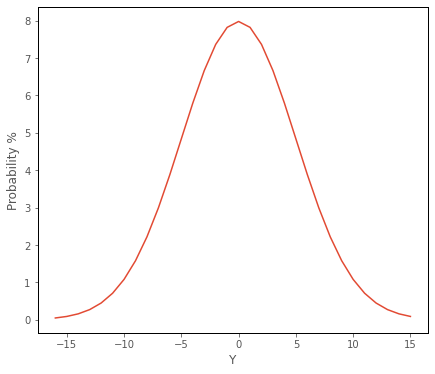

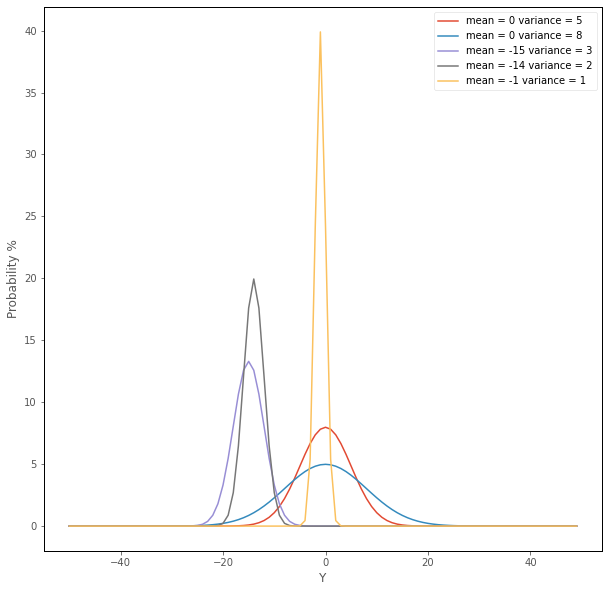

In [2]:
# turn this into function
def normal_pdf(y, y_hat, var):
  
  output = 1/np.sqrt(var**2 * 2 * np.pi) * np.e**(-(y - y_hat)**2/(2*var**2))
  
  return output

def normal_plot():
    y = np.arange(-16,16)

    prob = normal_pdf(y, 0, 5)

    plt.plot(y,prob*100) #line width was 20 in case you need to re-generate graphics for 3d plots
    plt.xlabel('Y')
    plt.ylabel('Probability %')
    plt.show()

    np.random.seed(2000)

    n_plots = 4
    mus = np.random.choice(np.arange(-20,21), replace = False, size = n_plots)
    sigmas = np.random.choice(np.arange(1,11), replace = False, size = n_plots)

    y = np.arange(-50,50)

    plt.figure(figsize = (10,10))

    plt.plot(y, normal_pdf(y, 0, 5)*100, label = 'mean = '+str(0)+ ' variance = '+str(5))

    for i in np.arange(len(mus)):

      prob = normal_pdf(y, mus[i], sigmas[i])

      plt.plot(y,prob*100, label = 'mean = '+str(mus[i])+ ' variance = '+str(sigmas[i]))
      plt.xlabel('Y')
      plt.ylabel('Probability %')

    plt.legend()
    plt.show()
    
normal_plot()

## Implementation

[with minimize with one predictor model]

## Interpretation (one predictor model)

## Multi-predictor Linear Regression

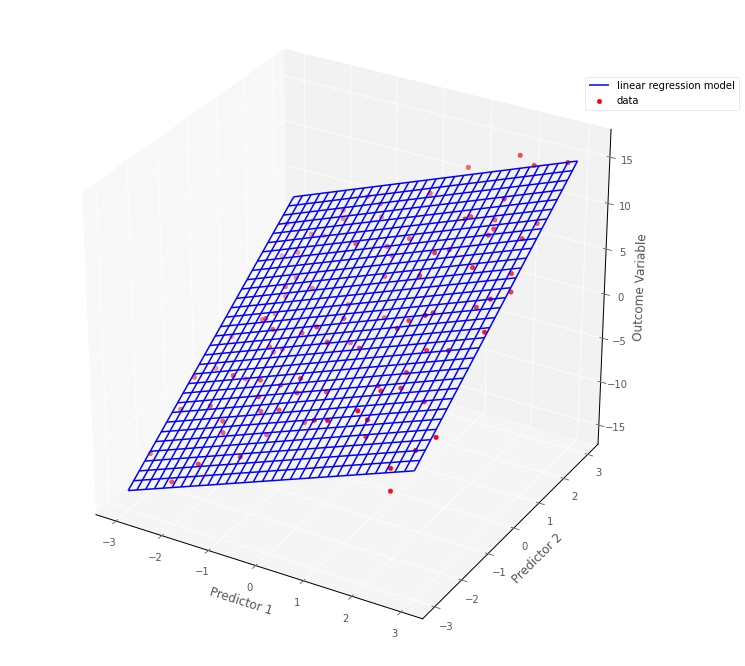

In [3]:
# show how linear regression works in multiple dimensions

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
 
x = np.outer(np.linspace(-3, 3, 32), np.ones(32))
y = x.copy().T # transpose
z = 2*x + 3*y

data_x = np.random.choice(np.linspace(-3, 3, 32), size = 100)
data_y = np.random.choice(np.linspace(-3, 3, 32), size = 100)
data_z = 2*data_x + 3*data_y + np.random.normal(0, 3, size = 100)

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize = (12,12))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_wireframe(x,y,z, color = 'blue', label = 'linear regression model')
ax1.scatter(data_x, data_y, data_z, color = 'red', label = 'data'  )
plt.xlabel('Predictor 1')
plt.ylabel('Predictor 2')
ax1.set_zlabel('Outcome Variable')
plt.legend(bbox_to_anchor = (1.1,0.9))
plt.show()

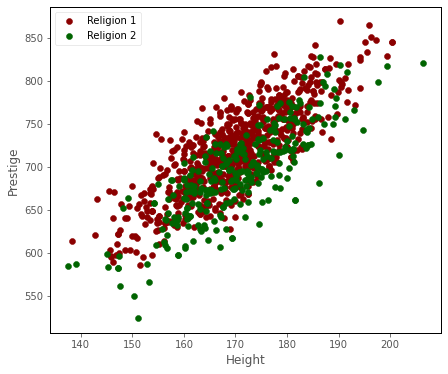

In [4]:
plt.scatter(df[df['religion'] == 1]['height'], df[df['religion'] == 1]['prestige'], label = 'Religion 1', color = 'darkred')
plt.scatter(df[df['religion'] == 0]['height'], df[df['religion'] == 0]['prestige'], label = 'Religion 2', color = 'darkgreen')
plt.xlabel('Height')
plt.ylabel('Prestige')
plt.legend()
plt.show()

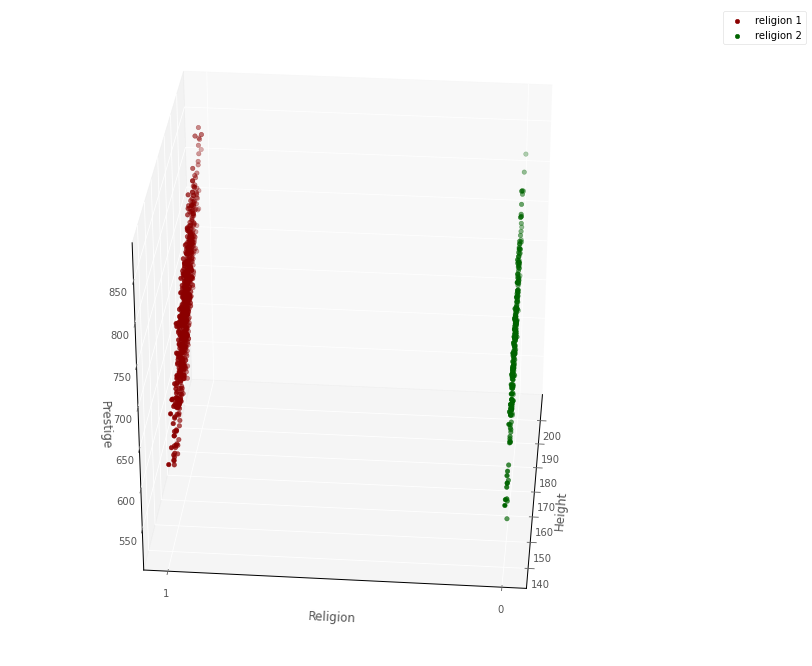

In [5]:
religion_1 = df[df['religion'] == 1]
religion_2 = df[df['religion'] == 0]

fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(religion_1['height'], religion_1['religion'] , religion_1['prestige'], color = 'darkred', label = 'religion 1'  )
ax1.scatter(religion_2['height'], religion_2['religion'] , religion_2['prestige'], color = 'darkgreen', label = 'religion 2'  )
ax1.set_yticks([0,1])
plt.xlabel('Height')
plt.ylabel('Religion')
ax1.set_zlabel('Prestige')
ax1.view_init(azim = 185)
plt.legend(bbox_to_anchor = (1.2,1))
plt.show()

In [6]:
import statsmodels.formula.api as smf

lin_reg_model = smf.ols('prestige ~ religion + height + religion*height', data = df).fit()

lin_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestige   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     728.3
Date:                Fri, 13 May 2022   Prob (F-statistic):          1.56e-250
Time:                        15:31:41   Log-Likelihood:                -4814.0
No. Observations:                1000   AIC:                             9636.
Df Residuals:                     996   BIC:                             9656.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          12.9980     27.826      0.467      0.641     -41.606      67.602
religion           10.5461     33.373      0.316      0.752     -54.943      76.035
height              3.9892      0.163     24.461      0.000       3.669       4.309
religion:height     0.1010      0.196      0.516      0.606      -0.283       0.485
==============================================================================
Omnibus:                        4.232   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                3.395
Skew:                          -0.004   Prob(JB):                        0.183
Kurtosis:                       2.715   Cond. No.                     9.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

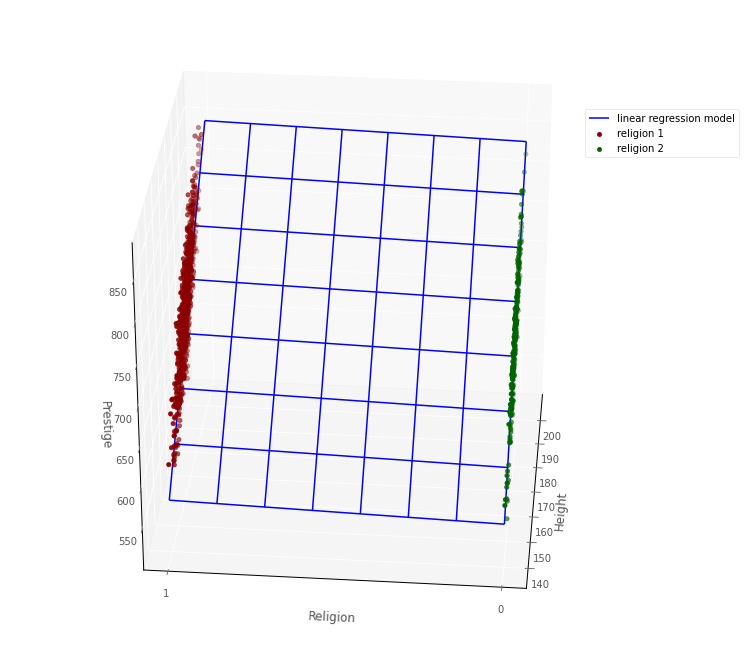

In [7]:
intercept, religion_slope, height_slope = lin_reg_model.params[:3]

height_x = np.linspace(np.min(df['height']), np.max(df['height']), 8)
religion_y = np.linspace(np.min(df['religion']), np.max(df['religion']), 8)
height_x, religion_y = np.meshgrid(height_x, religion_y)
prestige_z = intercept + height_slope * height_x.ravel() + religion_slope * religion_y.ravel()

fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_wireframe(height_x, religion_y,
                prestige_z.reshape(height_x.shape), label = 'linear regression model', color = 'blue')
ax1.scatter(religion_1['height'], religion_1['religion'] , religion_1['prestige'], color = 'darkred', label = 'religion 1'  )
ax1.scatter(religion_2['height'], religion_2['religion'] , religion_2['prestige'], color = 'darkgreen', label = 'religion 2'  )
ax1.view_init(azim = 185)
ax1.set_yticks([0,1])
plt.xlabel('Height')
plt.ylabel('Religion')
ax1.set_zlabel('Prestige')
ax1.legend(bbox_to_anchor = (1.1,0.85))
plt.show()


In [8]:
# checking if one religious group is taller than the other

lin_reg_model_2 = smf.ols('height ~ religion', data = df).fit()

lin_reg_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2597
Date:                Fri, 13 May 2022   Prob (F-statistic):              0.610
Time:                        15:31:41   Log-Likelihood:                -3768.1
No. Observations:                1000   AIC:                             7540.
Df Residuals:                     998   BIC:                             7550.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    170.2838      0.617    276.034      0.000     169.073     171.494
religion      -0.3729      0.732     -0.510      0.610      -1.809       1.063
==============================================================================
Omnibus:                        0.405   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.817   Jarque-Bera (JB):                0.290
Skew:                           0.008   Prob(JB):                        0.865
Kurtosis:                       3.082   Cond. No.                         3.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Interpretation (multiple predictors)

The coefficient of each predictor tells us the predicted difference in the outcome variable scores for two observations which differed *only* by a one unit score in that predictor. E.g. which had the same score on all other predictors.

The intercept tells us the predicted score on the outcome variable for an observation whose score on all other predictors was 0. 

## Other Chapters

1. [What is Statistical Modelling?]()
2. [Linear Regression]()
3. [Poisson Regression]()
4. [Binary Logistic Regression]()
5. [Multinomial Logistic Regression]()

***
By [pxr687](99_about_the_author.ipynb) 